In [1]:
import sys
import argparse
from typing import List, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf

In [18]:
def split_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    ecg_1 = df.iloc[1::2, :].to_numpy()
    ecg_2 = df.iloc[::2, :].to_numpy()

    train_ecg_1, labels_ecg_1 = ecg_1[:, 1:-2], ecg_1[:, -1]
    train_ecg_2, labels_ecg_2 = ecg_2[:, 1:-2], ecg_2[:, -1]

    return train_ecg_1, labels_ecg_1, train_ecg_2, labels_ecg_2

In [19]:
dataset_path = './dataset.csv'

df = pd.read_csv(dataset_path)

train_x1, train_y1, train_x2, train_y2 = split_data(df)

In [260]:
def create_model(input_shapes: Tuple[Tuple, Tuple]) -> tf.keras.Model():
    input_1 = tf.keras.Input(shape=input_shapes[0])
    layer_1 = tf.keras.layers.Dense(128, 'relu')(input_1)
    layer_1 = tf.keras.layers.Dense(64, 'relu')(layer_1)
    layer_1 = tf.keras.layers.Dense(64, 'relu')(layer_1)
    
    x = tf.keras.Model(inputs=input_1, outputs=layer_1)

    input_2 = tf.keras.Input(shape=input_shapes[1])
    layer_2 = tf.keras.layers.Dense(128, 'relu')(input_2)
    layer_2 = tf.keras.layers.Dense(64, 'relu')(layer_2)
    layer_2 = tf.keras.layers.Dense(64, 'relu')(layer_2)

    y = tf.keras.Model(inputs=input_2, outputs=layer_2)

    concatted = tf.keras.layers.Concatenate()([x.output, y.output])

    output = tf.keras.layers.Dense(3, activation='softmax')(concatted)

    model = tf.keras.Model(inputs=[input_1,input_2], outputs=output)
    # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    
    return model

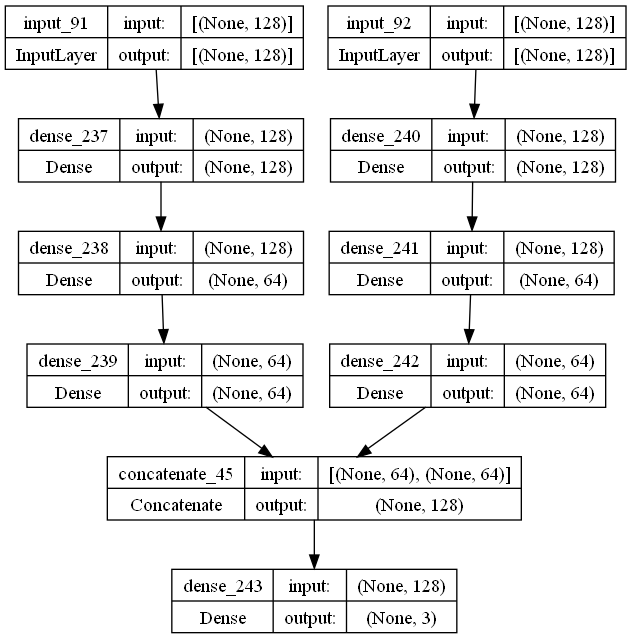

In [261]:
model = create_model(((128,), (128,)))

tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

In [262]:
dataset1 = tf.data.Dataset.from_tensor_slices(train_x1)
dataset2 = tf.data.Dataset.from_tensor_slices(train_x2)

mirrored_strategy = tf.distribute.MirroredStrategy()

dataset = tf.data.Dataset.zip((dataset1, dataset2))
dataset_label = tf.data.Dataset.from_tensor_slices(train_y1)
dataset = tf.data.Dataset.zip((dataset, dataset_label)).shuffle(64, reshuffle_each_iteration=False)

mirrored_strategy.experimental_distribute_dataset(dataset)

dataset = dataset.batch(64).shuffle(64, reshuffle_each_iteration=False)

DATASET_SIZE = float(dataset.__len__())

train_dataset = dataset.take(int(0.7 * DATASET_SIZE))
test_dataset = dataset.skip(int(0.7 * DATASET_SIZE))
test_dataset = test_dataset.take(int(0.3 * DATASET_SIZE))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [263]:
model = create_model(((128,), (128,)))

model.fit(train_dataset, epochs=150)

Epoch 1/150
20/20 [==============================] - 1s 895us/step - loss: 45.4131 - accuracy: 0.2835
Epoch 2/150
20/20 [==============================] - 0s 947us/step - loss: 14.2518 - accuracy: 0.1618
Epoch 3/150
20/20 [==============================] - 0s 947us/step - loss: 12.9733 - accuracy: 0.3031
Epoch 4/150
20/20 [==============================] - 0s 1000us/step - loss: 12.8585 - accuracy: 0.1928
Epoch 5/150
20/20 [==============================] - 0s 1ms/step - loss: 13.8843 - accuracy: 0.1250
Epoch 6/150
20/20 [==============================] - 0s 1ms/step - loss: 11.6194 - accuracy: 0.2565
Epoch 7/150
20/20 [==============================] - 0s 947us/step - loss: 12.3140 - accuracy: 0.2083
Epoch 8/150
20/20 [==============================] - 0s 947us/step - loss: 7.1245 - accuracy: 0.2761
Epoch 9/150
20/20 [==============================] - 0s 947us/step - loss: 11.4793 - accuracy: 0.3644
Epoch 10/150
20/20 [==============================] - 0s 948us/step - loss: 10.1663 - 

In [264]:
model.evaluate(test_dataset)

8/8 [==============================] - 0s 1ms/step - loss: 0.2353 - accuracy: 0.9355


[0.23532439768314362, 0.935546875]

In [265]:
train_dataset.__len__()
test_dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=8>

2/2 [==============================] - 0s 2ms/step
[128, 95, 289]


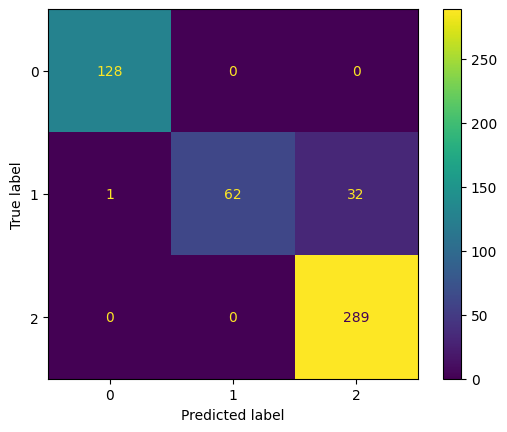

In [269]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

true = []
pred = []

label = [0, 0, 0]

for data, labels in test_dataset.as_numpy_iterator():
    model_pred = model.predict(data);
    model_pred = [np.argmax(p) for p in model_pred]

    for x in labels:
        label[int(x)] += 1

    true += list(labels)
    pred += model_pred

print(label)

conf = confusion_matrix(true, pred)

disp = ConfusionMatrixDisplay(conf, display_labels=[0, 1, 2])

disp.plot()
plt.show()

In [270]:
model.summary()

Model: "model_145"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_93 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_94 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 dense_244 (Dense)              (None, 128)          16512       ['input_93[0][0]']               
                                                                                                  
 dense_247 (Dense)              (None, 128)          16512       ['input_94[0][0]']               
                                                                                          

In [287]:
model.save('my_h5_model.h5')

In [288]:
tf.keras.models.load_model("my_h5_model.h5")